In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import scipy

In [2]:
res, sigma, edge = 35, 0, 0.0
run_ID = f'{res}-{sigma}-{edge}'
fname = f'data/rmaps/{run_ID}/rmaps.npz'
print(f'Loaded {run_ID} --- Last modified at {time.ctime(os.stat(fname).st_mtime)}')
rmaps = np.load(fname)

fname = f'data/rmaps/{run_ID}/fpspeccorr.npz'
print(f'Loaded {run_ID} --- Last modified at {time.ctime(os.stat(fname).st_mtime)}')
fpspeccorr = np.load(fname)

Loaded 35-0-0.0 --- Last modified at Thu May 23 11:46:00 2024
Loaded 35-0-0.0 --- Last modified at Thu May 23 11:46:01 2024


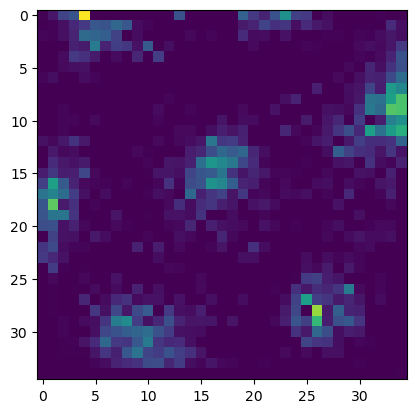

In [3]:
gtype = 'wty'
nid = 198
rmap = rmaps[gtype][nid]
plt.imshow(rmap)

In [4]:
from scores import GridScorer
scorer = GridScorer(0)

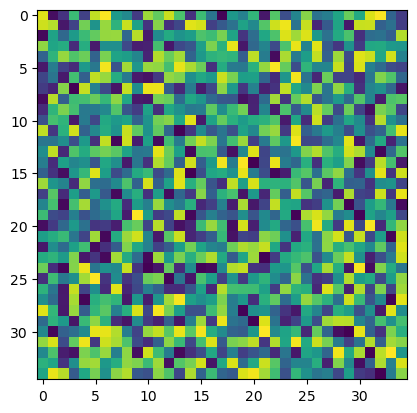

In [5]:
rmap = np.random.rand(35,35)
#rmap = abs(np.random.randn(35,35))
#rmap = np.random.randn(35,35)
#mask = scorer._get_mask((35,35),ratio=0.4)
#rmap[~mask] = 0
#rmap[mask] = 1
#rmap = np.zeros((35,35))
#x, y = np.meshgrid(np.arange(35),np.arange(35))
#mask = np.sqrt((x-10)**2+(y-10)**2)< 7
#rmap[mask] = 1
plt.imshow(rmap)

In [6]:
npad = 110
padded = np.pad(rmap, ((npad,npad),(npad,npad)), mode='constant', constant_values=rmap.mean())
#padded = np.pad(rmap, ((npad,npad),(npad,npad)))

fpx  = np.abs(np.fft.fftshift(np.fft.fft2(padded)))**2

# Mask the center peak with a flipped Gaussian
xcoord,ycoord = np.meshgrid(np.arange(fpx.shape[0]), np.arange(fpx.shape[1]))
cx, cy = np.argwhere(fpx==fpx.max())[0]
gfilter = 1- np.exp(-((xcoord-cx)**2 + (ycoord-cy)**2)/2)
mat = fpx*(gfilter==1)

mat = mat / np.nanmax(mat)
mat[mat < 0.25] = 0

mask = scorer._get_mask(mat.shape,ratio=0.9,remove_center=True)
assert mat.shape == mask.shape
corr = []
for angle in range(360):
    rot_mat = scipy.ndimage.rotate(mat, angle, reshape=False)
    corr.append(np.corrcoef(mat[mask], rot_mat[mask])[0,1])
corr = np.array(corr)
#scipy.ndimage.gaussian_filter(corr,sigma=5,mode='wrap')

#cpol = scorer.calc_cpol(mat, 0, (mat.shape[0]/2)*0.7)
#cpol = scipy.ndimage.gaussian_filter(cpol,sigma=3,mode='wrap')
#plt.plot(cpol)

#corr[:30] = 0
#corr[150:210] = 0
#corr[330:] = 0

ftcorr = np.fft.fft(corr)
score_norm = np.sum(corr**2) #- (corr.sum()**2)/len(corr) # Calculate the denominator for the grid score
fpcorr = 2*(abs(ftcorr)**2)[:10]/len(corr) / (score_norm + 1e-10)

#fig, ax = plt.subplots(1,1,figsize=(3,3),dpi=150)
#ax.scatter(np.arange(10)[1:],fpspeccorr[gtype][nid][1:])
#ax.set_ylabel('Normalized Fourier Power')
#ax.set_xlabel('Fourier Components')
#sns.despine(ax=ax)
#fig.savefig(f'images/presentation/methods/{nid}_fourier.png',bbox_inches='tight')

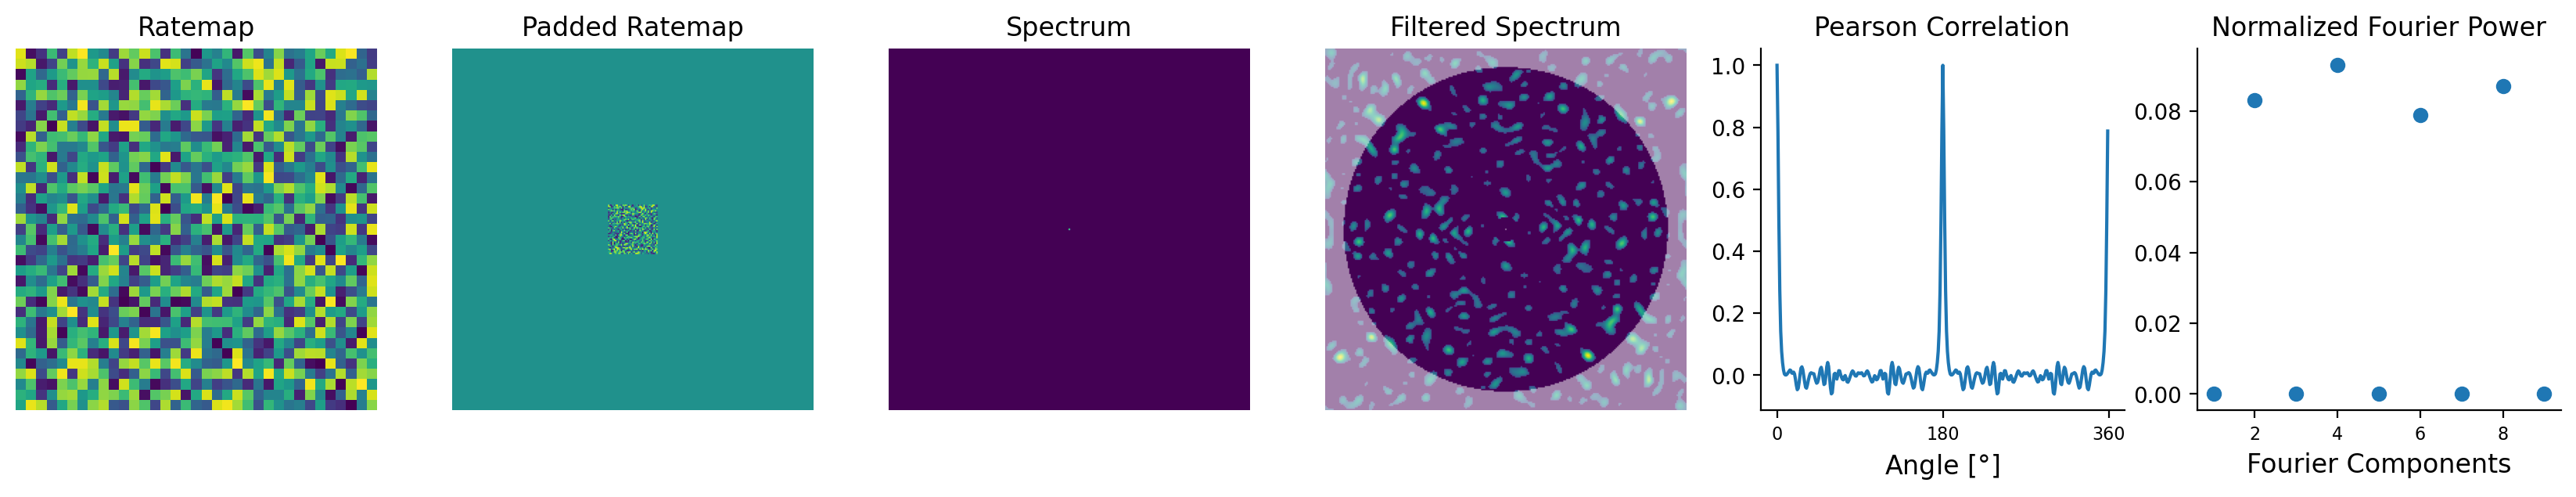

In [7]:
fig, axs = plt.subplots(1,6,figsize=(21,3), dpi=200, gridspec_kw={'wspace':0.2})
ax = axs[0]
ax.imshow(rmap)
ax.set_title('Ratemap')
ax.axis('off')
ax = axs[1]
ax.imshow(padded)
ax.set_title('Padded Ratemap')
ax.axis('off')
ax = axs[2]
ax.imshow(fpx)
ax.set_title('Spectrum')
ax.axis('off')
ax = axs[3]
ax.imshow(mat, alpha=mask.astype(float)*0.5+0.5)
ax.set_title('Filtered Spectrum')
ax.axis('off')
ax = axs[4]
ax.plot(corr)
ax.set_xticks([0,180,360])
ax.set_xticklabels([0,180,360],fontsize=8)
ax.set_xlabel(r'Angle [$\degree$]', fontsize=12)
ax.set_title('Pearson Correlation', fontsize=12)
#ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
#ax.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=8)
sns.despine(ax=ax)
ax = axs[5]
ax.scatter(np.arange(1,10), fpcorr[1:])
ax.set_xticks([2,4,6,8])
ax.set_xticklabels([2,4,6,8],fontsize=8)
ax.set_title('Normalized Fourier Power', fontsize=12)
ax.set_xlabel('Fourier Components', fontsize=12)
sns.despine(ax=ax)
fig.savefig(f'images/presentation/methods/rand_mean_pad.png',bbox_inches='tight')
#fig.savefig(f'images/presentation/methods/dot.png',bbox_inches='tight')
#fig.savefig(f'images/presentation/methods/{nid}.png',bbox_inches='tight')
